Interesting questions for data exploration:
* is site_id significant? Should we train different models for different sites (people in japan have different search / booking habits compared to the UK for instance).
* same question for visitor_location_country_id
* visitor_hist_starrating and visitor_hist_adr_usd are expected to be predictive, how many values are missing?
* Higher booking prob when price_usd is significantly lower than prop_log_historical_price, conditioned on the property_id
* Higher booking prob when in promotion
* random_bool - how often are random display sorts presented?
* Exploring booking behaviour, when is it more or less likely that a search will result in a booking (regardless of what hotels are shown), can this be predicted?
* Price and availability relative to competitor +1 good, (-1/0) bad, null. Does this booking probability all else being equal?

Sanity checks:
* srch_destination_id should be strongly correlated to the prop_country_id, prop_id
* prop_starrating correlated with visitor_hist_starrating
* price_usd correlated with visitor_hist_adr_usd

Aggregation ideas:
* comp_agg_rate_sum, comp_agg_rate_cnt (summing an counting)
* comp_agg_inv_sum, comp_agg_inv_cnt

In [24]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [18]:
df = pd.read_csv('data/training_set_VU_DM.csv')

In [19]:
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


In [71]:
# how many flags are NA
sum(df.booking_bool.isna()), sum(df.click_bool.isna())

print("how many unique searches are there? ", df.srch_id.nunique())

print("how many unique properties are there? ", df.prop_id.nunique())

print("how many unique destinations are there? ", df.srch_destination_id.nunique())

how many unique searches are there?  199795
how many unique properties are there?  129113
how many unique destinations are there?  18127


In [72]:
print("the percentage of impressions resulting in a click", 100*sum(df.click_bool)/len(df.click_bool))
print("the percentage of impressions resulting in a booking", 100*sum(df.booking_bool)/len(df.booking_bool))

the percentage of impressions resulting in a click 4.474858254172207
the percentage of impressions resulting in a booking 2.7910511305481442


<Axes: >

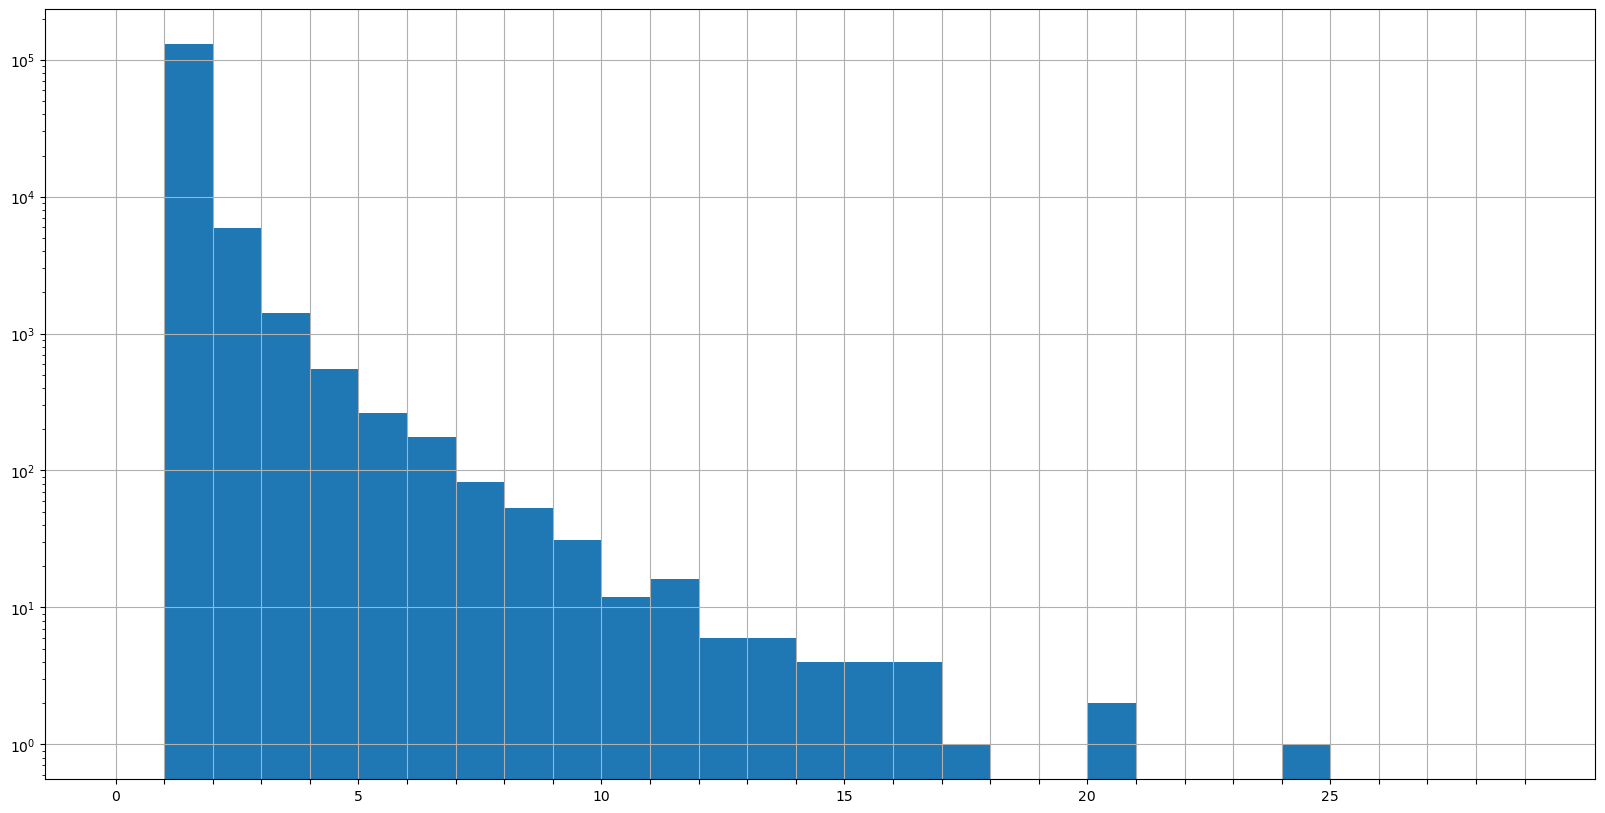

In [34]:
# Get a set of search ids which resulted in a booking
ids_with_booking = set(df[df.booking_bool == 1].srch_id)

fig, ax = plt.subplots(figsize=(20,10))
# the spacing between x ticks should be 1
ax.set_xticks(range(30))
# the spacing between x tick labels should be 5
xticks = np.array([None for _ in range(30)])
for i in range(30//5):
    xticks[5*i]=5*i
ax.set_xticklabels(xticks)
# set the axis to logarithmic
ax.set_yscale('log')

# Histogram of number of clicks for every search id with booking, the histogram bar width should be 1
# The histogram is plotted on an axis where the x tick distance is 1 and the tick label is shown every 5th tick
df[df.srch_id.isin(ids_with_booking)].groupby('srch_id').click_bool.sum().hist(bins=range(30), log=True)

In [35]:
# sanity check: assert that there are no search ids with a booking but no click
assert len(set(df[df.booking_bool == 1].srch_id) - set(df[df.click_bool == 1].srch_id)) == 0

## random_bool - how often are random display sorts presented?

In [50]:
# Is there any search id where all the displayed properties have the random_bool set to true?
# df.groupby('srch_id').agg({'random_bool':"sum", 'site_id':"count"})
np.any(df.groupby('srch_id').random_bool.nunique() > 1)
# Observation: random_bool applies to an entire search not just individual properties (either all properties are shown or none)

False

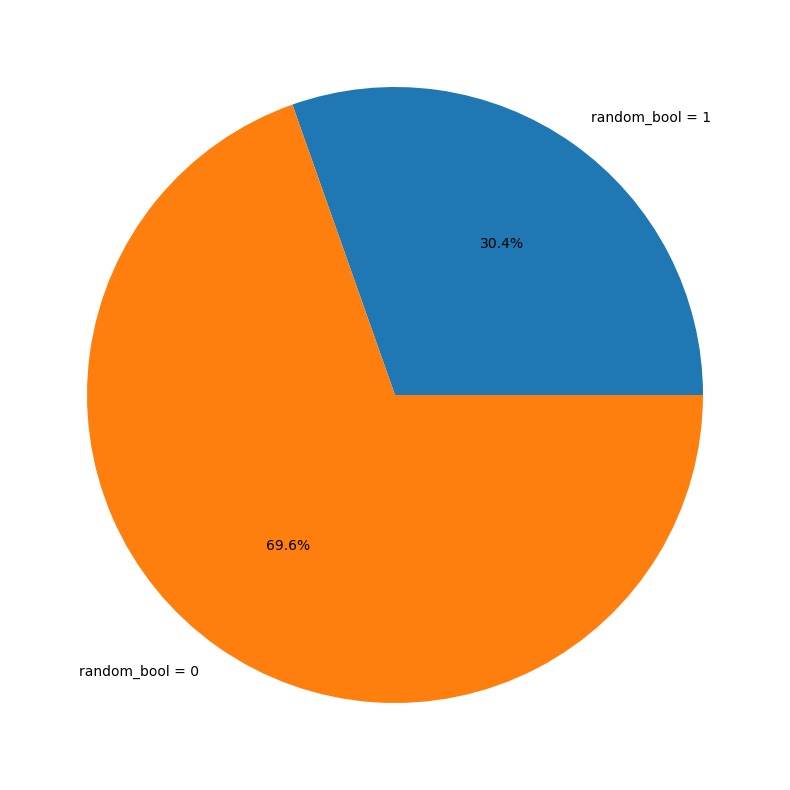

In [56]:
# pie chart of how many searches have random_bool set to true and how many to false
fig, ax = plt.subplots(figsize=(20,10))
ax.pie([len(set(df[df.random_bool == 1].srch_id)),
        len(set(df[df.random_bool == 0].srch_id))], labels=['random_bool = 1', 'random_bool = 0'], autopct='%1.1f%%');

## random_bool: how many searcher result in bookings and clicks for the two different value

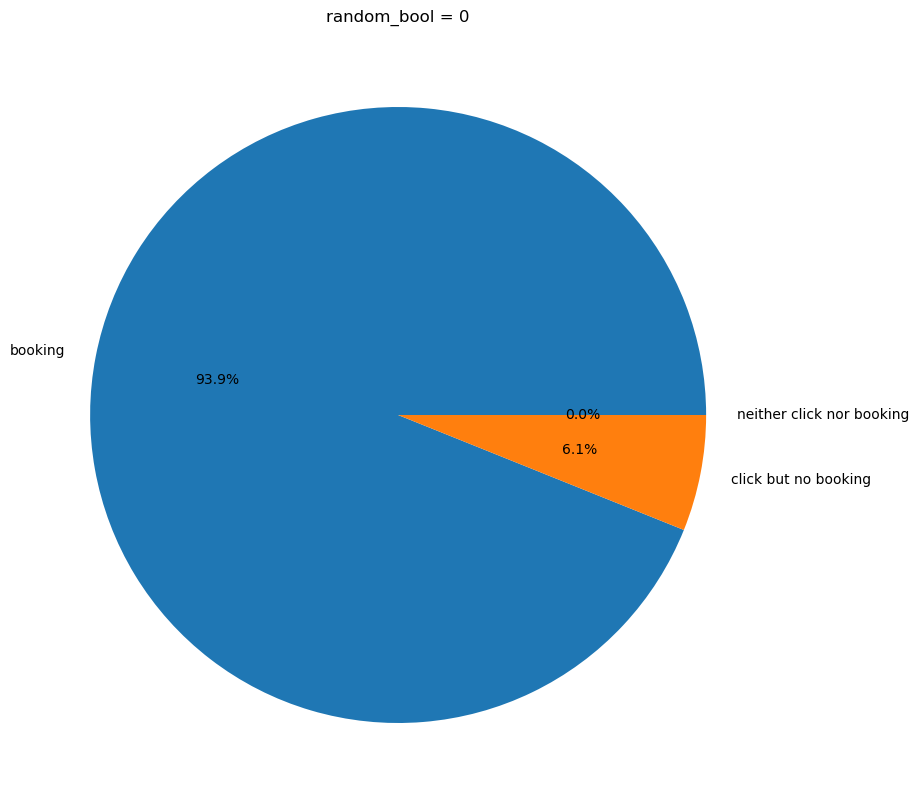

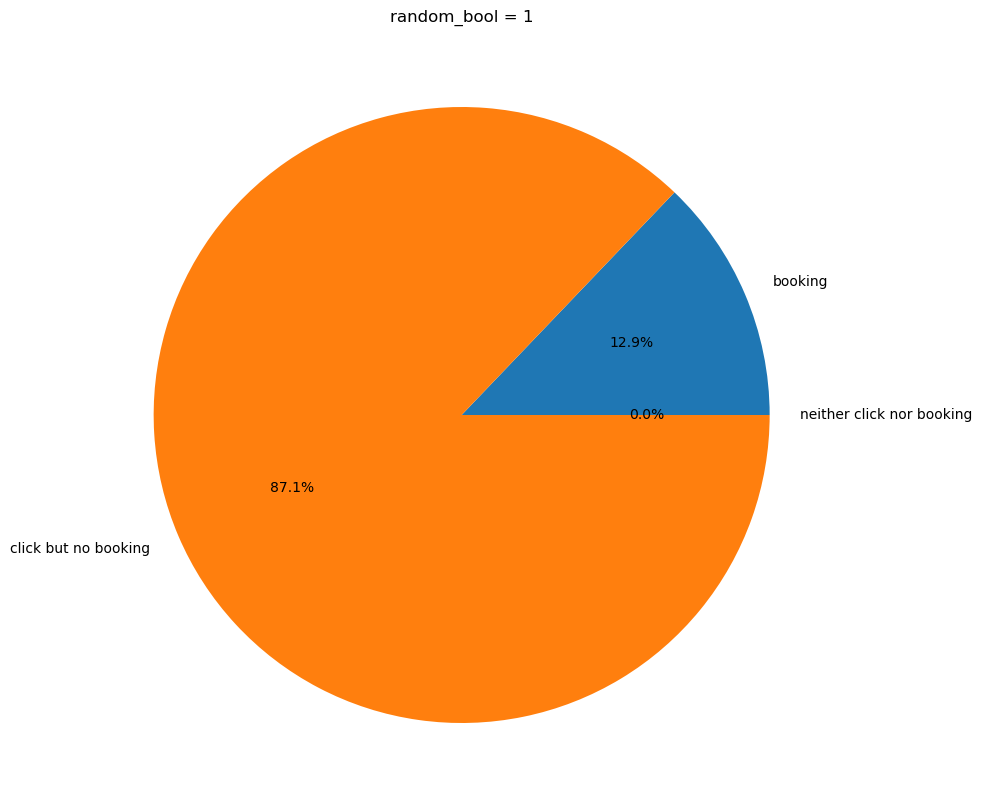

In [59]:
def pie_chart_random_bool(tg_val):
    id_subset = set(df[df.random_bool == tg_val].srch_id)
    df_filt = df[df.srch_id.isin(id_subset)]
    ids_with_booking = set(df_filt[df_filt.booking_bool == 1].srch_id)

    # pie chart with meaningful labels and legend of how many searches have a booking, a click but no booking, neither click nor booking
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_title(f'random_bool = {tg_val}')
    ax.pie([len(ids_with_booking),
            len(set(df_filt[df_filt.click_bool == 1].srch_id) - ids_with_booking),
            len(set(df_filt.srch_id) - set(df_filt[df_filt.click_bool == 1].srch_id))], labels=['booking', 'click but no booking', 'neither click nor booking'], autopct='%1.1f%%');

pie_chart_random_bool(0)
pie_chart_random_bool(1)

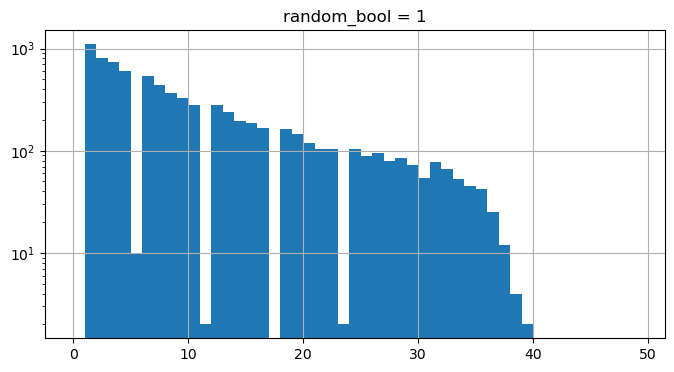

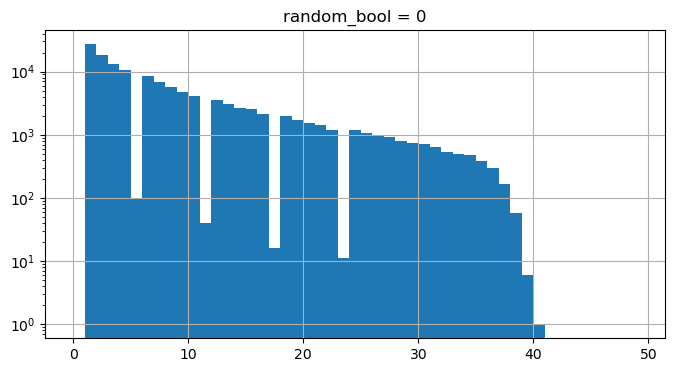

In [69]:
# Histogram of positions that where booked
def booking_pos_hist(random_bool):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.set_title(f'random_bool = {random_bool}')
    ax.set_yscale('log')
    id_subset = set(df[df.random_bool == random_bool].srch_id)
    df_filt = df[df.srch_id.isin(id_subset)]
    df_filt.query("booking_bool==1").position.hist(bins=range(50), ax=ax)

booking_pos_hist(random_bool=1)
booking_pos_hist(random_bool=0)

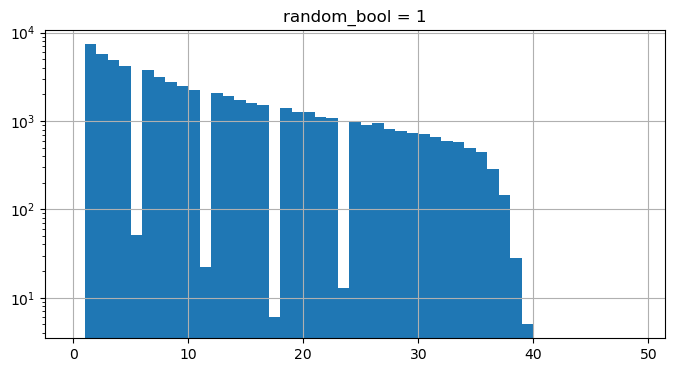

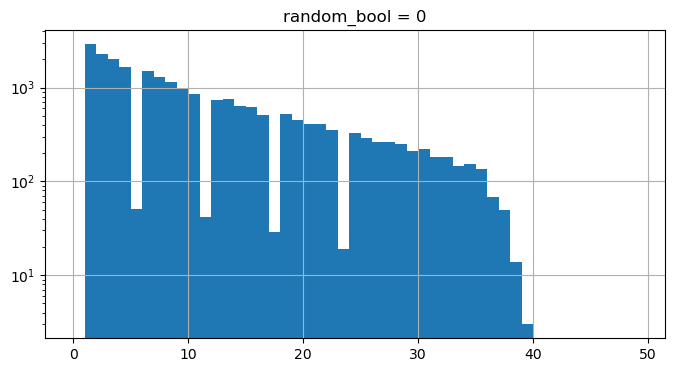

In [70]:
def click_pos_hist(random_bool):
    fig, ax = plt.subplots(figsize=(8,4))
    ax.set_title(f'random_bool = {random_bool}')
    ax.set_yscale('log')
    id_subset = set(df[df.random_bool == random_bool].srch_id)
    df_filt = df[df.srch_id.isin(id_subset)]
    df_filt.query("click_bool==1 and booking_bool==0").position.hist(bins=range(50), ax=ax)

click_pos_hist(random_bool=1)
click_pos_hist(random_bool=0)